In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = Path().resolve().parent
DF = BASE_DIR / "data" / "Raw"

df = pd.read_csv(DF / "tracking_week_1.csv")
print("Week 1 Tracking:", df.head())

Week 1 Tracking:        gameId  playId    nflId     displayName  frameId    frameType  \
0  2022091200      64  35459.0  Kareem Jackson        1  BEFORE_SNAP   
1  2022091200      64  35459.0  Kareem Jackson        2  BEFORE_SNAP   
2  2022091200      64  35459.0  Kareem Jackson        3  BEFORE_SNAP   
3  2022091200      64  35459.0  Kareem Jackson        4  BEFORE_SNAP   
4  2022091200      64  35459.0  Kareem Jackson        5  BEFORE_SNAP   

                    time  jerseyNumber club playDirection      x      y     s  \
0  2022-09-13 00:16:03.5          22.0  DEN         right  51.06  28.55  0.72   
1  2022-09-13 00:16:03.6          22.0  DEN         right  51.13  28.57  0.71   
2  2022-09-13 00:16:03.7          22.0  DEN         right  51.20  28.59  0.69   
3  2022-09-13 00:16:03.8          22.0  DEN         right  51.26  28.62  0.67   
4  2022-09-13 00:16:03.9          22.0  DEN         right  51.32  28.65  0.65   

      a   dis       o    dir                 event  
0  0.37  0

In [ ]:
# identifying how many man_in_motion events there are
df["event"].value_counts().head(30)

event
ball_snap                    44804
line_set                     44252
huddle_break_offense         34477
first_contact                28865
tackle                       27715
pass_forward                 24794
pass_arrived                 18791
man_in_motion                15824
handoff                      15341
pass_outcome_caught          15249
play_action                   8188
pass_outcome_incomplete       8142
shift                         6095
out_of_bounds                 4968
run                           2507
qb_sack                       1495
touchdown                     1104
fumble                        1081
dropped_pass                   920
pass_tipped                    759
fumble_offense_recovered       598
pass_outcome_interception      598
pass_outcome_touchdown         506
play_submit                    483
qb_kneel                       460
fumble_defense_recovered       414
qb_slide                       253
qb_strip_sack                  230
qb_spike      

In [43]:
# Plays that contain man in motion, and extracting just the plays that had man in motion
# joining gameId on playId so filtering out just the specific games with that playId
# isolate motion plays
MotionPlays = (
    df.loc[df["event"].eq("man_in_motion"), ["gameId", "playId"]]
    .drop_duplicates()
)

MotionDF = df.merge(MotionPlays, on = ["gameId", "playId"], how = "inner")
MotionDF.shape

(2670093, 18)

In [44]:
# only plays that have both events and correct ordering
bounds = (
    MotionDF.loc[MotionDF["event"].isin(["line_set", "ball_snap"]),
                 ["gameId", "playId", "frameId", "event"]]
    .dropna(subset=["frameId"])
)

LineSetB = (
    bounds.loc[bounds["event"].eq("line_set")]
    .groupby(["gameId", "playId"], as_index = False)["frameId"]
    .min()
    .rename(columns = {"frameId": "LineSetFrame"})
)

BallSnapB = (
    bounds.loc[bounds["event"].eq("ball_snap")]
    .groupby(["gameId", "playId"], as_index = False)["frameId"]
    .min()
    .rename(columns = {"frameId": "BallSnapFrame"})
)

PlayBounds = LineSetB.merge(BallSnapB, on = ["gameId", "playId"], how = "inner")
PlayBounds = PlayBounds.loc[PlayBounds["BallSnapFrame"] > PlayBounds["LineSetFrame"]]

PlayBounds.head()

,gameId,playId,LineSetFrame,BallSnapFrame
0,2022090800,80,23,88
1,2022090800,101,46,106
2,2022090800,212,79,104
3,2022090800,236,51,93
4,2022090800,299,61,153


In [45]:
# Filter down to rows between lineset and ball snap
# merge bounds back in, then filter with between

PreSnapDF = MotionDF.merge(PlayBounds, on = ["gameId", "playId"], how = "inner")

PreSnapDF = PreSnapDF.loc[
    PreSnapDF["frameId"].between(PreSnapDF["LineSetFrame"], PreSnapDF["BallSnapFrame"],
                                 inclusive = "both")
].copy()

PreSnapDF.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,LineSetFrame,BallSnapFrame
42,2022091200,64,35459.0,Kareem Jackson,43,BEFORE_SNAP,2022-09-13 00:16:07.7,22.0,DEN,right,51.88,29.07,0.34,0.26,0.03,261.81,303.38,line_set,43,114
43,2022091200,64,35459.0,Kareem Jackson,44,BEFORE_SNAP,2022-09-13 00:16:07.8,22.0,DEN,right,51.86,29.08,0.33,0.23,0.03,263.41,300.68,NaN,43,114
44,2022091200,64,35459.0,Kareem Jackson,45,BEFORE_SNAP,2022-09-13 00:16:07.9,22.0,DEN,right,51.83,29.09,0.29,0.37,0.03,264.02,286.38,NaN,43,114
45,2022091200,64,35459.0,Kareem Jackson,46,BEFORE_SNAP,2022-09-13 00:16:08,22.0,DEN,right,51.80,29.10,0.31,0.39,0.03,264.02,276.52,NaN,43,114
46,2022091200,64,35459.0,Kareem Jackson,47,BEFORE_SNAP,2022-09-13 00:16:08.1,22.0,DEN,right,51.76,29.10,0.34,0.37,0.03,265.34,273.05,NaN,43,114


In [ ]:
# testing one play
# picking the first play
One = PlayBounds.iloc[0]
gid, pid = int(One["gameId"]), int(One["playId"])
ls, bs = int(One["LineSetFrame"]), int(One["BallSnapFrame"])

p = PreSnapDF.loc[(PreSnapDF["gameId"] == gid) & (PreSnapDF["playId"] == pid)].copy()
p.head()

club
BUF         11
LA          11
football     1
Name: count, dtype: int64

In [54]:
## find motion start frame
ms = p.loc[p["event"].eq("man_in_motion"), "frameId"].dropna().min()
ms = int(ms) if pd.notna(ms) else None
ms

61

In [52]:
print("Line Set:", ls)
print("Motion Start:", ms)
print("Ball Snap:", bs)

Line Set: 23
Motion Start: 61
Ball Snap: 88


In [ ]:
# Identify Motion Player
p_m = p[p["frameId"].between(ms, bs)].copy()
p_m = p_m[p_m["nflId"].notna()]

p_m = p_m.sort_values(["nflId", "frameId"])

p_m["dx"] = p_m.groupby("nflId")["x"].diff()
p_m["dy"] = p_m.groupby("nflId")["y"].diff()
p_m["step_dist"] = np.sqrt(p_m["dx"]**2 + p_m["dy"]**2)

travel = p_m.groupby("nflId")["step_dist"].sum().sort_values(ascending = False)
MotionID = travel.index[0]
MotionID

Original line_set frame: 23
Using lineup snapshot frame: 23
Motion start frame: 61


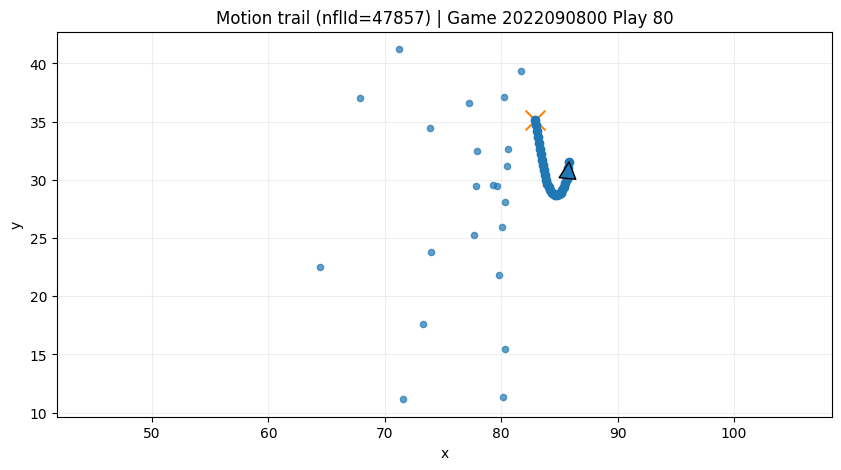

In [95]:
# Plot snapshot + trail
p_ls = p[p["frameId"] == ls].copy()

trail = p[(p["nflId"] == MotionID) &
          (p["frameId"].between(ms, bs, inclusive="both"))].sort_values("frameId")

plt.figure(figsize=(10, 5))

# All players at line_set (small dots)
plt.scatter(p_ls["x"], p_ls["y"], s=20, alpha=0.7)

# Motion trail (thicker line + bigger markers)
plt.plot(trail["x"], trail["y"], linewidth=4, marker="o", markersize=6)

# Start and end markers so you can’t miss it
plt.scatter(trail["x"].iloc[0], trail["y"].iloc[0], s=200, marker="x")
plt.scatter(trail["x"].iloc[-1], trail["y"].iloc[-1], s=20, marker="o")

plt.annotate(
    "",
    xy=(trail["x"].iloc[-1], trail["y"].iloc[-1]),
    xytext=(trail["x"].iloc[-2], trail["y"].iloc[-2]),
    arrowprops=dict(width=3)
)

plt.title(f"Motion trail (nflId={int(MotionID)}) | Game {gid} Play {pid}")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True, alpha=0.2)
plt.show()

In [ ]:
# confirm offense and defense, importing plays csv
plays = pd.read_csv("plays.csv")
playInfo = plays[(plays["gameId"] == gid) & (plays["playId"] == pid)]
playInfo[["possessionTeam", "defensiveTeam"]]

,possessionTeam,defensiveTeam
2660,BUF,LA


In [ ]:
# distinguishing the team
off_club = playInfo["possessionTeam"].iloc[0]
def_club = playInfo["defensiveTeam"].iloc[0]

off_club, def_club

('BUF', 'LA')

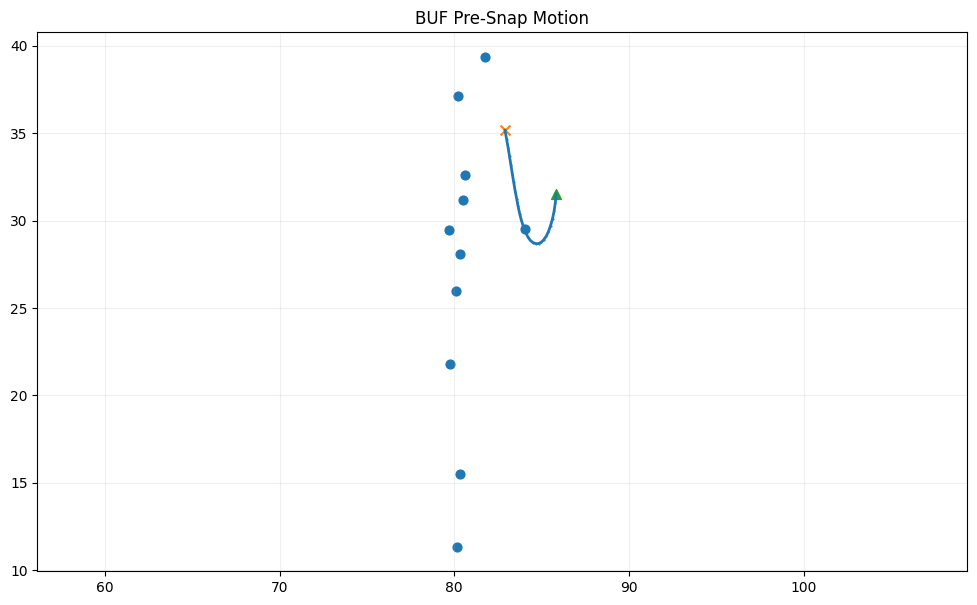

In [105]:
# Clean offensive snapshot + motion trail
p_ls = p[p["frameId"] == ls_plot].copy()

off_ls = p_ls[(p_ls["club"] == off_club) & (p_ls["nflId"].notna())]
def_ls = p_ls[(p_ls["club"] == def_club) & (p_ls["nflId"].notna())]

plt.figure(figsize=(12,7))

# Offense
plt.scatter(off_ls["x"], off_ls["y"], s=40)

# Motion trail
plt.plot(trail["x"], trail["y"], linewidth=2, marker="o", markersize=.5)
plt.scatter(trail["x"].iloc[0], trail["y"].iloc[0], s=50, marker="x")
plt.scatter(trail["x"].iloc[-1], trail["y"].iloc[-1], s=50, marker="^")

plt.title(f"{off_club} Pre-Snap Motion")
plt.axis("equal")
plt.grid(True, alpha=0.2)
plt.show()

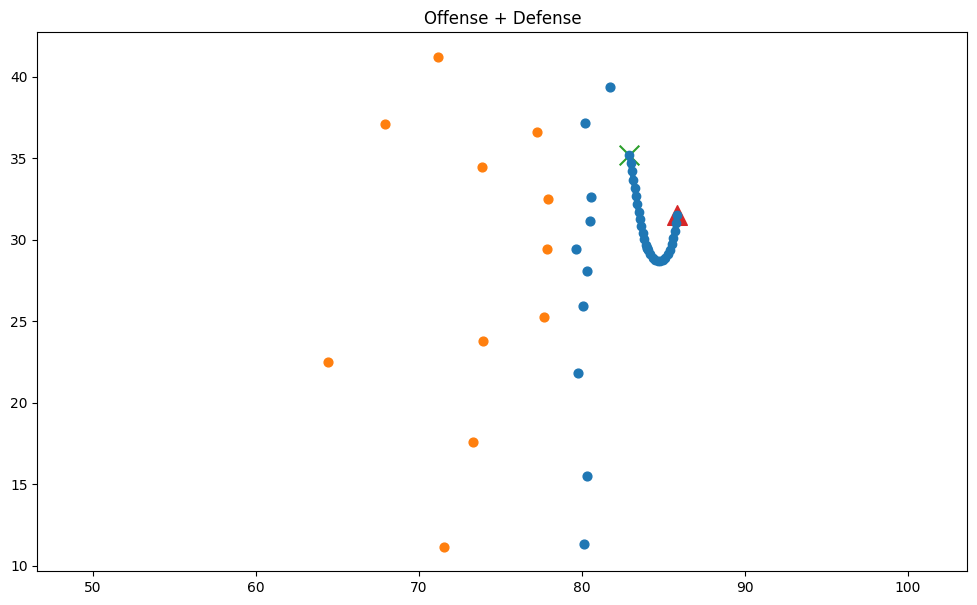

In [106]:
# add the defensive 
plt.figure(figsize=(12,7))

# Offense
plt.scatter(off_ls["x"], off_ls["y"], s=40)

# Defense
plt.scatter(def_ls["x"], def_ls["y"], s=40)

# Motion trail
plt.plot(trail["x"], trail["y"], linewidth=4, marker="o", markersize=6)
plt.scatter(trail["x"].iloc[0], trail["y"].iloc[0], s=200, marker="x")
plt.scatter(trail["x"].iloc[-1], trail["y"].iloc[-1], s=200, marker="^")

plt.title("Offense + Defense")
plt.axis("equal")
plt.show()